### QTM 350 Project
### Looking at the Global NOAA dataset

##### by Karoline Lin, Rachel Shanahan, John Cox, Erin O'Reilly, Hayley Roesler
##### on April 23, 2020


In [4]:
!pip install jupyterthemes
from jupyterthemes import get_themes
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('oceans16')

    100% |████████████████████████████████| 7.0MB 6.2MB/s eta 0:00:01
    100% |████████████████████████████████| 51kB 18.5MB/s ta 0:00:01
    100% |████████████████████████████████| 9.7MB 4.7MB/s eta 0:00:01
    100% |████████████████████████████████| 112kB 30.9MB/s ta 0:00:01
  Running setup.py bdist_wheel for prometheus-client ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/1c/54/34/fd47cd9b308826cc4292b54449c1899a30251ef3b506bc91ea
Successfully built prometheus-client
sparkmagic 0.12.5 has requirement notebook<6.0,>=4.2, but you'll have notebook 6.0.3 which is incompatible.
notebook 6.0.3 has requirement jupyter-core>=4.6.1, but you'll have jupyter-core 4.4.0 which is incompatible.
jupyter-client 6.1.3 has requirement jupyter-core>=4.6.0, but you'll have jupyter-core 4.4.0 which is incompatible.
  Found existing installation: jupyter-client 5.2.3
    Uninstalling jupyter-client-5.2.3:
      Successfully uninstalled jupyter-client-5.2.3
  Found existing installation

In [5]:
from IPython.display import display, Markdown, Image

In [6]:
image_bucket = 'global-noaa'

In [7]:
def show_image(bucket, key, img_width = 500):
    return Image(url='https://s3.amazonaws.com/' + bucket + '/' + key, width=img_width)


In [8]:
show_image(image_bucket, 'NOAA.png', 400)

With the increasing urgency for us, as citizens of the world, to pay attention to the ways in which our planet is changing before us, it is imperative that we pay attention to the data that we do have. As today, April 22, 2020 is Earth Day, we thought it was opportune to look at the NOAA Integrated Surface Database (ISD) that can be found on Amazon Web Service’s open data registry. This data is compiled from a series of over 35,000 stations worldwide, and is constantly being updated daily. 

We decided that in an effort to create a cohesive understanding of our climate over time, it would be appropriate to compare a weather station over multiple years and various observations. This way, with the same elevation and location at our disposal, we might be able to locate possible trends or differences in the output of our findings as well as the frequency of observations.

The NOAA, which is our National Ocean and Atmospheric Administration, is a federal U.S. agency that is responsible for monitoring and trying to improve our environment and climate. The NOAA data is responsible for driving industries worth billions of dollars as well important research initiatives. Through public accessibility, NOAA hopes to cultivate a system of innovation among data scientists and environmentalists alike. As individuals of this targeted audience of data science users, we thought it would be interesting and inspiring to see what we could do with data of this magnitude and importance at our disposal.


Above, we also created an S3 bucket to store the pictures we are including in this Jupyter and named it global-noaa. 


To begin our analysis of this data, we went through a series of steps to set up our notebook environment and the tools that we would need to import the large database into our SageMaker. This included importing boto3, botocore, pandas, display, and Markdown (just to start).

In [9]:
import boto3
import botocore
import pandas as pd

We created an S3 bucket that we wanted to work with, and named it after the name of the dataset we would be using so that it would be easy to discern.

In [10]:
s3 = boto3.client('s3')
s3_resource = boto3.resource('s3')

In [11]:
def create_bucket(bucket):
    import logging

    try:
        s3.create_bucket(Bucket=bucket)
    except botocore.exceptions.ClientError as e:
        logging.error(e)
        return 'Bucket ' + bucket + ' could not be created.'
    return 'Created or already exists ' + bucket + ' bucket.'

Using the Amazon Resource Name (ARN), listed in both the online data AWS registry and the github repository containing all of the open-access dataset, we pulled the dataset that we wanted. Our bucket that we pulled using the ARN for this particular dataset was called “global-noaa-hourly-pds”. From this, we were able to import and download the exact CSV files that we wanted to work with. The particular station number that we decided to look at was “62019099999” which is located in Sirte, Libya.

In [12]:
create_bucket('open-data-analytics-noaa-global')

ERROR:root:An error occurred (BucketAlreadyExists) when calling the CreateBucket operation: The requested bucket name is not available. The bucket namespace is shared by all users of the system. Please select a different name and try again.


'Bucket open-data-analytics-noaa-global could not be created.'

In [13]:
def list_buckets(match=''):
    response = s3.list_buckets()
    if match:
        print(f'Existing buckets containing "{match}" string:')
    else:
        print('All existing buckets:')
    for bucket in response['Buckets']:
        if match:
            if match in bucket["Name"]:
                print(f'  {bucket["Name"]}')

In [14]:
list_buckets(match='open')

Existing buckets containing "open" string:


In [15]:
def list_bucket_contents(bucket, match='', size_mb=0):
    bucket_resource = s3_resource.Bucket(bucket)
    total_size_gb = 0
    total_files = 0
    match_size_gb = 0
    match_files = 0
    for key in bucket_resource.objects.all():
        key_size_mb = key.size/1024/1024
        total_size_gb += key_size_mb
        total_files += 1
        list_check = False
        if not match:
            list_check = True
        elif match in key.key:
            list_check = True
        if list_check and not size_mb:
            match_files += 1
            match_size_gb += key_size_mb
            print(f'{key.key} ({key_size_mb:3.0f}MB)')
        elif list_check and key_size_mb <= size_mb:
            match_files += 1
            match_size_gb += key_size_mb
            print(f'{key.key} ({key_size_mb:3.0f}MB)')

    if match:
        print(f'Matched file size is {match_size_gb/1024:3.1f}GB with {match_files} files')            
    
    print(f'Bucket {bucket} total size is {total_size_gb/1024:3.1f}GB with {total_files} files')

In [16]:
#str(list_bucket_contents(bucket='noaa-global-hourly-pds', match='', size_mb=250)).split()
#this command above lists the contents and data size of each bucket; we put this command in markdown for now as it produces a huge number of CSV files

In [29]:
show_image(image_bucket, 'earth1.jpg', 400)

In [18]:
def preview_csv_dataset(bucket, key, rows=10):
    data_source = {
            'Bucket': bucket,
            'Key': key
        }
    # Generate the URL to get Key from Bucket
    url = s3.generate_presigned_url(
        ClientMethod = 'get_object',
        Params = data_source
    )

    data = pd.read_csv(url, nrows=rows)
    return data

From here, we combined all of our datasets that we were using into one data frame using the append command. At this point, we decided to make several manipulations of our dataset in order to better understand climate trends. 

In [19]:
# create starting data frame: station 62019099999, year 1950
df = preview_csv_dataset(bucket='noaa-global-hourly-pds', key= '1950/62019099999.csv', rows=100)

# create new column for year
df['YEAR'] = '1950'

In [20]:
# Looking at station 62019099999
# Manually select and combine every 10 years of station's data
year_list = [1960, 1973, 1980, 1990, 2000, 2010, 2020]
for year in year_list:
    df_temp = preview_csv_dataset(bucket='noaa-global-hourly-pds', key= str(year) + '/62019099999.csv', rows=100)
    df_temp['YEAR'] = str(year)
    df = pd.concat([df, df_temp])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [21]:
# clean up columns to eventually compare this station's data by year
columns = ['STATION', 'DATE', 'YEAR', 'SOURCE','LATITUDE','LONGITUDE','TMP','ELEVATION','WND','NAME']
df = pd.DataFrame(df, columns = columns)
df

,STATION,DATE,YEAR,SOURCE,LATITUDE,LONGITUDE,TMP,ELEVATION,WND,NAME
0,62019099999,1950-01-03T12:00:00,1950,4,31.2,16.583333,"+0178,1",14.0,"270,1,N,0026,1","SIRTE, LY"
1,62019099999,1950-01-04T12:00:00,1950,4,31.2,16.583333,"+0167,1",14.0,"290,1,N,0067,1","SIRTE, LY"
2,62019099999,1950-01-06T12:00:00,1950,4,31.2,16.583333,"+0144,1",14.0,"110,1,N,0046,1","SIRTE, LY"
3,62019099999,1950-01-08T12:00:00,1950,4,31.2,16.583333,"+0189,1",14.0,"340,1,N,0046,1","SIRTE, LY"
4,62019099999,1950-01-09T12:00:00,1950,4,31.2,16.583333,"+0161,1",14.0,"230,1,N,0010,1","SIRTE, LY"
5,62019099999,1950-01-11T12:00:00,1950,4,31.2,16.583333,"+0267,1",14.0,"080,1,N,0026,1","SIRTE, LY"
6,62019099999,1950-01-12T12:00:00,1950,4,31.2,16.583333,"+0172,1",14.0,"310,1,N,0010,1","SIRTE, LY"
7,62019099999,1950-01-13T12:00:00,1950,4,31.2,16.583333,"+0172,1",14.0,"050,1,N,0031,1","SIRTE, LY"
8,62019099999,1950-01-17T12:00:00,1950,4,31.2,16.583333,"+0161,1",14.0,"200,1,N,0046,1","SIRTE, LY"
9,62019099999,1950-01-18T12:00:00,1950,4,31.2,16.583333,"+9999,9",14.0,"160,1,N,0026,1","SIRTE, LY"


In [30]:
show_image(image_bucket, 'ocean.jpg', 400)

In [23]:
# clean temperature column from NOAA format into degrees Celsius
import re
df['TMP'] = df['TMP'].str.replace(r',\d', '')
df['TMP'] = df['TMP'].str.replace(r'\+', '')
df['TMP'] = df['TMP'].astype(float)
df['TMP'] = df['TMP'] / 100

In [24]:
# ground temperatures are not 99 degrees Celsius - remove outlier rows
indexNames = df[ df['TMP'] == 99.99 ].index
df = df.drop(indexNames , inplace=False)

In [25]:
# average temperature by year
averages = df.groupby('YEAR')['TMP'].mean()
averages = pd.DataFrame(averages)
averages

,TMP
YEAR,
1950,2.170854
1960,1.386585
1973,1.481707
1980,1.303659
1990,1.448780
2000,1.222317
2010,1.697805
2020,1.582805


In [26]:
# set up graphs
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Text(0, 0.5, 'TEMPERATURE (Celsius)')

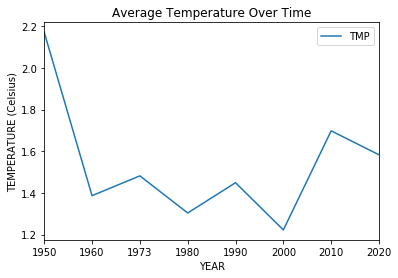

In [27]:
# graph temperatures across years
averages.plot(title = "Average Temperature Over Time").set_ylabel("TEMPERATURE (Celsius)")

In [31]:
show_image(image_bucket, 'climatechange.jpg', 400)